## Task 2: Solving  the mean-field α-Ω dynamo equations in the kinematic regime

In [1]:
# importing the required modules
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

fig_path = "figures/Task-2/"
fig_save = True

In [2]:
# defining spatial deritivative functions
def spatial_derivative(B, dx, order = 4, ghost_zone_type = 'symmetric'):

    dBdx = np.zeros(B.shape)
    ddBddx = np.zeros(B.shape)

    
    B = np.copy(B) 
    
    if order not in ['np',2, 4]:
        raise ValueError("Order should be 'np' = 2 or 4")
    
    if ghost_zone_type not in ['anti-symmetric', 'symmetric', 'relative anti-symmetric', 'smooth',None]:
        raise ValueError('ghost_zone_type should be anti-symmetric, symmetric, relative anti-symmetric or None')

    if order == 'np':
        ghost_zone = 5 # 5 cells on each side
    else:
        ghost_zone = int(order/2)
    
    if ghost_zone_type == 'symmetric':
        B = np.pad(B, ((0, 0), (ghost_zone, ghost_zone)), mode='symmetric')
    
    elif ghost_zone_type == 'anti-symmetric':
        B = np.pad(B, ((0, 0), (ghost_zone, ghost_zone)), mode='reflect') # makes symmetric padding
        for i in range(ghost_zone): 
            B[:,i] = - B[:, i] # making anti-symmetric at the start of the array
            B[:, -1 - i] = - B[:, -1 - i] # making anti-symmetric at the end of the array

    elif ghost_zone_type == 'relative anti-symmetric':
        B = np.pad(B, ((0, 0), (ghost_zone, ghost_zone)), mode='constant')
        for i in range(ghost_zone):
            B[:,i] = (2 * B[:,ghost_zone]) - B[:,ghost_zone + ghost_zone - i] # correcting the start of the array
            B[:, -1 - i] = 2 * B[:,-ghost_zone - 1] - B[:, (- ghost_zone - 1) - ghost_zone + i] # correcting the end of the array
    
    elif ghost_zone_type == 'smooth':
        B = np.pad(B, ((0, 0), (ghost_zone, ghost_zone)), mode='reflect', reflect_type='odd')
    
    else:
        B = np.pad(B, ((0, 0), (ghost_zone, ghost_zone)), mode='constant') # zero padding

    if order == 2:
        for i in range(ghost_zone, B.shape[1] - ghost_zone):
            dBdx[:,i-ghost_zone] = ((- B[:,i - 1]) + (B[:,i + 1])) / (2 * dx)
            ddBddx[:,i-ghost_zone] = (B[:,i - 1] - (2 * B[:, i]) + B[:,i + 1]) / (dx ** 2)
    elif order == 4:
        for i in range(ghost_zone, B.shape[1] - ghost_zone):
            dBdx[:,i-ghost_zone] = ((B[:,i - 2]) - (8 * B[:,i - 1]) + (8 * B[:,i + 1]) - (B[:,i + 2])) / (12 * dx)
            ddBddx[:,i-ghost_zone] = ((- B[:,i - 2]) + (16 * B[:,i - 1]) - (30 * B[:,i]) + (16 * B[:,i + 1]) - (B[:,i + 2])) / (12 * (dx ** 2))
    else:
        dBdx = np.gradient(B, dx, axis=1)
        ddBddx = np.gradient(dBdx, dx, axis=1)
        
        # removing the ghost zones
        dBdx = dBdx[:,ghost_zone:-ghost_zone]
        ddBddx = ddBddx[:,ghost_zone:-ghost_zone]
            
    
    return dBdx, ddBddx

In [3]:
def first_derivative_dYdx_FD(Y, dx, order, ghost_zone_type):
    
    dYdx = np.zeros(Y.shape)
    
    Y = np.copy(Y) # to avoid modifying the original array
    
    if order not in ['np', 2, 4]:
        raise ValueError("Order should be 'np', 2 or 4")
    
    if ghost_zone_type not in ['anti-symmetric', 'symmetric', 'relative anti-symmetric','smooth', None]:
        raise ValueError('ghost_zone_type should be anti-symmetric, symmetric, relative anti-symmetric or None')

    if order == 'np':
        ghost_zone = 5 # 5 cells on each side
    else:
        ghost_zone = int(order/2)
    
    if ghost_zone_type == 'symmetric':
        Y = np.pad(Y, (ghost_zone, ghost_zone), mode='reflect')
        
    elif ghost_zone_type == 'anti-symmetric':
        Y = np.pad(Y, (ghost_zone, ghost_zone), mode='reflect') # makes symmetric padding
        for i in range(ghost_zone): 
            Y[i] = - Y[ i] # making anti-symmetric at the start of the array
            Y[ -1 - i] = - Y[ -1 - i] # making anti-symmetric at the end of the array
    elif ghost_zone_type == 'relative anti-symmetric':
        Y = np.pad(Y, (ghost_zone, ghost_zone), mode='constant')
        for i in range(ghost_zone):
            Y[i] = (2 * Y[ghost_zone]) - Y[ghost_zone + ghost_zone - i] # correcting the start of the array
            Y[ -1 - i] = 2 * Y[-ghost_zone - 1] - Y[ (- ghost_zone - 1) - ghost_zone + i] # correcting the end of the array
    
    elif ghost_zone_type == 'smooth':
        Y = np.pad(Y, (ghost_zone, ghost_zone), mode='reflect', reflect_type='odd')
          
    else:
        Y = np.pad(Y, (ghost_zone, ghost_zone), mode='constant') # zero padding
    
    # print(f"shape of Y is {Y.shape}")
    
    if order == 2:
        for i in range(ghost_zone, len(Y) - ghost_zone):
            dYdx[i-ghost_zone] = ((- Y[i - 1]) + (Y[i + 1])) / (2 * dx)
    elif order == 4:
        for i in range(ghost_zone, len(Y) - ghost_zone):
            dYdx[i-ghost_zone] = ((Y[i - 2]) - (8 * Y[i - 1]) + (8 * Y[i + 1]) - (Y[i + 2])) / (12 * dx)
    else:
        dYdx = np.gradient(Y, dx, axis=1)
        
        # removing the ghost zones
        dYdx = dYdx[ghost_zone:-ghost_zone]
            
    # update with other orders
    
    return dYdx

In [4]:
def sim_field(r_i, r_f, Nr, T, Nt, B_r0, B_phi0, dBrdt, dBphidt, order = 4, ghost_zone_type = 'symmetric', iterations_to_save = None):
 
    dr = (r_f - r_i) / (Nr - 1)  # Spatial step size
    dt = T / Nt  # Time step size
    
    # Create arrays to store the solution in time
    B_list = []

    # creating initial conditions from z, B_r0 and B_phi0
    
    r = np.linspace(r_i, r_f, Nr)
    B = np.zeros((2, Nr))
    
    B[0, :] = B_r0(r, 0, 0) # first row is B_r
    B[1, :] = B_phi0(r, 0, 0) # second row is B_phi
    
    if iterations_to_save is None:
        iterations_to_save = [0, Nt]
    elif iterations_to_save == 'all':
        iterations_to_save = list(range(Nt + 1))

    if 0 in iterations_to_save:
        B_list.append(np.copy(B))
    
    # RK4 time-stepping block 
    
    for n in tqdm(range(1, Nt + 1)):
        # Compute spatial derivatives
        dBdr, ddBddr = spatial_derivative(B, dr, order, ghost_zone_type)

        k1_r = dBrdt(B[0], B[1], dBdr[0], ddBddr[0], (n - 1) * dt)
        k1_phi = dBphidt(B[0], B[1], dBdr[1], ddBddr[1], (n - 1) * dt)
        
        k2_r = dBrdt(B[0] + (0.5 * dt * k1_r), B[1] + (0.5 * dt * k1_phi), dBdr[0], ddBddr[0], ((n-0.5) * dt))
        k2_phi = dBphidt(B[0] + (0.5 * dt * k1_r), B[1] + (0.5 * dt * k1_phi), dBdr[1], ddBddr[1], ((n-0.5) * dt))
        
        k3_r = dBrdt(B[0] + (0.5 * dt * k2_r), B[1] + (0.5 * dt * k2_phi), dBdr[0], ddBddr[0], ((n-0.5) * dt))
        k3_phi = dBphidt(B[0] + (0.5 * dt * k2_r), B[1] + (0.5 * dt * k2_phi), dBdr[1], ddBddr[1], ((n-0.5) * dt))
        
        k4_r = dBrdt(B[0] + (dt * k3_r), B[1] + (dt * k3_phi), dBdr[0], ddBddr[0], n * dt)
        k4_phi = dBphidt(B[0] + (dt * k3_r), B[1] + (dt * k3_phi), dBdr[1], ddBddr[1], n * dt)
        
        B[0, :] += (dt / 6) * (k1_r + (2 * k2_r) + (2 * k3_r) + k4_r)
        B[1, :] += (dt / 6) * (k1_phi + (2 * k2_phi) + (2 * k3_phi) + k4_phi)
        
        # print(B)
        
        if n in iterations_to_save:
            B_list.append(np.copy(B))
    
    B_list = np.array(B_list)
    
    return B_list


In [5]:
# defining constants and parameters
eta = 1
r_i = 0.01  # start of spatial domain
r_f = 10.01 # end of spatial domain
T = 1.0  # Total simulation time
Nr = 100  # Number of spatial grid points
Nt = 5000  # Number of time steps
h = 1
order = 4 # order of the finite difference scheme
ghost_zone_type = 'symmetric' # type of the ghost zone
iterations_to_save = 'all' # which time steps to save
iterations_to_save_plot = [int(i * Nt/8) for i in range(8 + 1)] # which time steps to plot

r = np.linspace(r_i, r_f, Nr)
dr = (r_f - r_i) / (Nr - 1)


# defining initial conditions
def B_phi0(r, phi, z):
    return (4*np.sin(((r - r_i)/(r_f - r_i))*np.pi)) - (np.sin(((r - r_i)/(r_f - r_i))*5*np.pi)) - (np.sin(((r - r_i)/(r_f - r_i))*4*np.pi))

def B_r0(r, phi, z):
    return 0

# definiing the time evolution of the magnetic field Br
def dBrdt(Br, Bphi, dBrdr, ddBrdr, t):
    return (- (2/(np.pi*h)) * R_alpha * alpha_cap* Bphi) + (eta * (ddBrdr + (dBrdr / r) - (Br/(r ** 2)) - (((np.pi ** 2) / (4 * (h**2))) * Br)))

# definiing the time evolution of the magnetic field Bphi
def dBphidt(Br, Bphi, dBphidr, ddBphidr, t):
    return (R_omega * Br) + (eta * (ddBphidr + (dBphidr / r) - (Bphi/(r ** 2)) - (((np.pi ** 2) / (4 * (h**2))) * Bphi)))



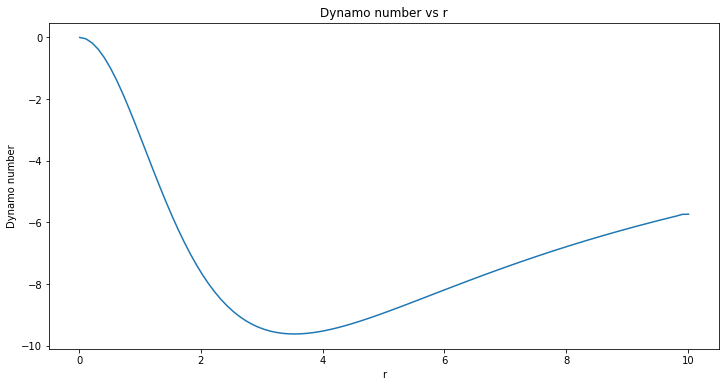

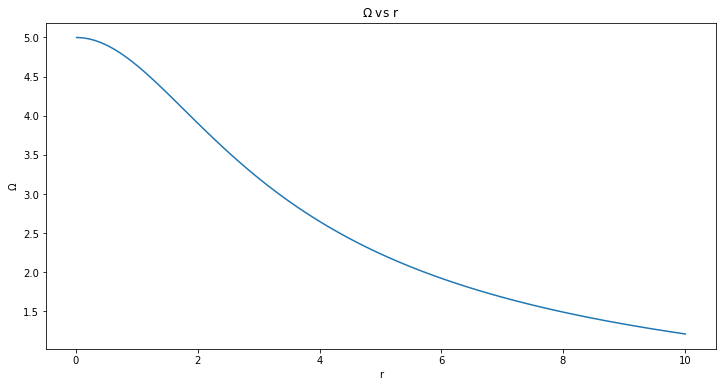

In [6]:
omega_0 = 5
r_omega = 2.5
h = 1
alpha = 5
alpha_cap = 1 #

# defining the spatial dependent omega
omega = omega_0 / (np.sqrt(1 + (r / r_omega) ** 2))

# defining q
#neg_q_omega = r * first_derivative_dYdx_FD(omega, dr, order = 4, ghost_zone_type='smooth')
neg_q_omega = r * first_derivative_dYdx_FD(omega, dr, order = 4, ghost_zone_type='smooth')
R_alpha = alpha * h / eta
R_omega = (neg_q_omega * (h ** 2)) / eta

D = R_alpha * R_omega

# plotting the fynamo number vs r
plt.figure(figsize=(12, 6))
plt.plot(r, D)
plt.xlabel('r')
plt.ylabel('Dynamo number')
plt.title('Dynamo number vs r')
if fig_save:
    plt.savefig(fig_path + 'Dynamo_vs_r.png')
plt.show()

# plotting omega vs r
plt.figure(figsize=(12, 6))
plt.plot(r, omega)
plt.xlabel('r')
plt.ylabel(r'$\Omega$')
plt.title(r'$\Omega$ vs r')
if fig_save:
    plt.savefig(fig_path + 'omega_vs_r.png')
plt.show()

In [7]:
B_list = sim_field(r_i , r_f, Nr, T, Nt, B_r0, B_phi0, dBrdt, dBphidt, order , ghost_zone_type, iterations_to_save)

100%|██████████| 5000/5000 [00:05<00:00, 890.77it/s]


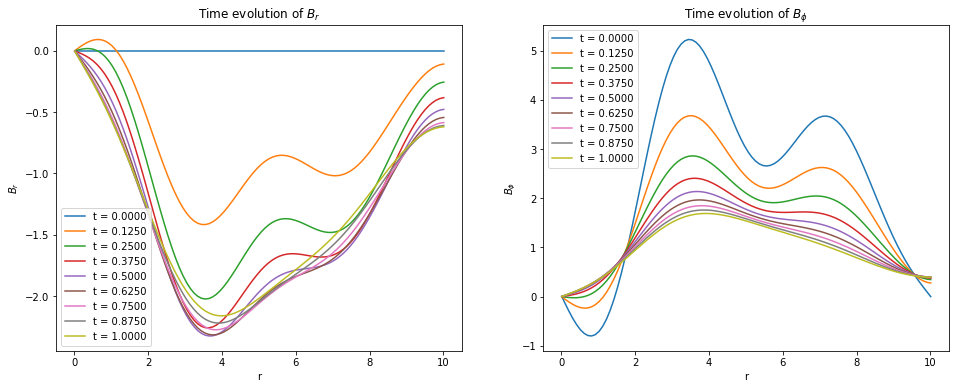

In [8]:
# plotting Br and Bphi time evolition in two plots side by side
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

for i, ax in enumerate(axs):
    for j in range(len(iterations_to_save_plot)):
        ax.plot(r, B_list[iterations_to_save_plot[j], i], label=f't = {iterations_to_save_plot[j] * T/Nt:.4f}')
    ax.set_xlabel('r')
    if i == 0:
        name = r'$B_r$'
    else:
        name = r'$B_{\phi}$'
    ax.set_ylabel(name)
    ax.set_title(f'Time evolution of {name}')
    ax.legend()


if fig_save:
    plt.savefig(fig_path + 'Br_Bphi_evolve_t.png')
plt.show()

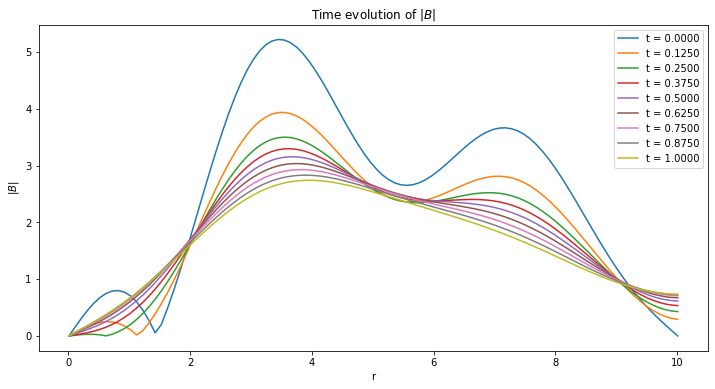

In [9]:
# plotting magnetic field strength time evolution

B_strength = np.sqrt(B_list[:, 0] ** 2 + B_list[:, 1] ** 2)

plt.figure(figsize=(12, 6))
for j in range(len(iterations_to_save_plot)):
    plt.plot(r, B_strength[iterations_to_save_plot[j]], label=f't = {iterations_to_save_plot[j] * T/Nt:.4f}')
plt.xlabel('r')
plt.ylabel(r'$|B|$')
plt.title('Time evolution of $|B|$')
plt.legend()
if fig_save:
    plt.savefig(fig_path + 'B_evolution_t.png')
plt.show()

### Magnetic Decay

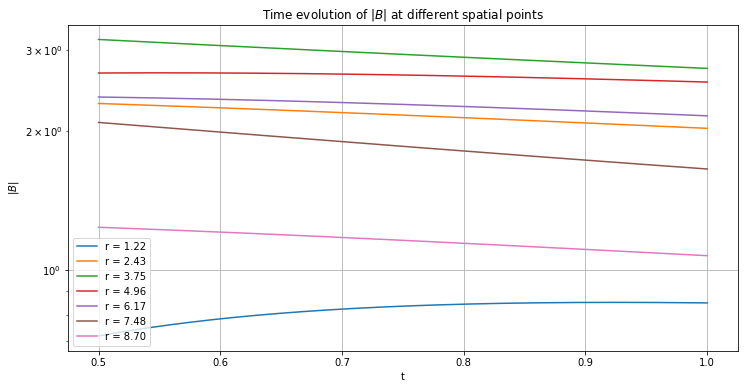

In [10]:
B_strength2 = B_strength.T

# plotting magnetic field strength at 7 different spatial points
cutoff_index = Nt // 2

plt.figure(figsize=(12, 6))
for i in np.linspace(0, Nr - 1, 9, dtype=int)[1:-1]:
    plt.plot(np.linspace(0, T, Nt + 1)[cutoff_index:], B_strength2[i][cutoff_index:], label=f'r = {r[i]:.2f}')
plt.yscale('log')
plt.xlabel('t')
plt.ylabel(r'$|B|$')
plt.title('Time evolution of $|B|$ at different spatial points')
plt.grid()
plt.legend()
if fig_save:
    plt.savefig(fig_path + 'B_st_evolve_t_at_r.png')
plt.show()

Decay rate is -0.1030


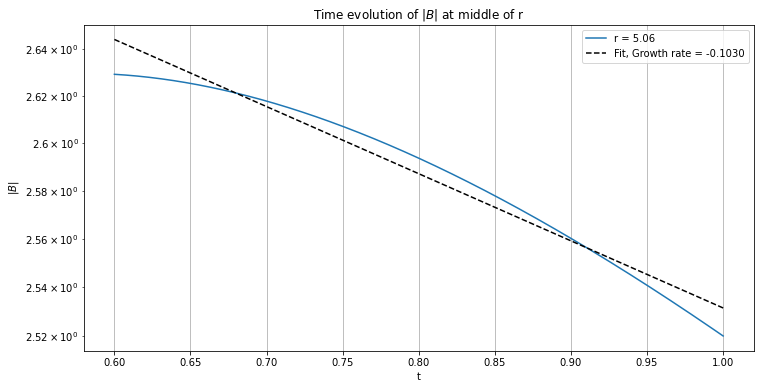

In [11]:
# plotting the magnetic field strength decay at r = 5

cutoff_index = 3 * Nt // 5
plt.figure(figsize=(12, 6))
plt.plot(np.linspace(0, T, Nt + 1)[cutoff_index:], B_strength2[Nr // 2][cutoff_index:], label = f'r = {r[Nr // 2]:.2f}')
plt.yscale('log')
plt.xlabel('t')
plt.ylabel(r'$|B|$')

# finding the decay rate

t = np.linspace(0, T, Nt + 1)[cutoff_index:]
B = B_strength2[Nr // 2][cutoff_index:]

slope, intercept = np.polyfit(t, np.log10(B), 1)
growth_rate = 10**(slope) - 1
print(f'Decay rate is {growth_rate:.4f}')

# plotting the fit
plt.plot(t, 10**(slope * t + intercept),'--k', label = f'Fit, Growth rate = {growth_rate:.4f}')
plt.grid()
plt.title('Time evolution of $|B|$ at middle of r')
plt.legend()
if fig_save:
    plt.savefig(fig_path + 'B_evolve_t_at_mid_r.png')
plt.show()

### Evolution of pitch angle with r

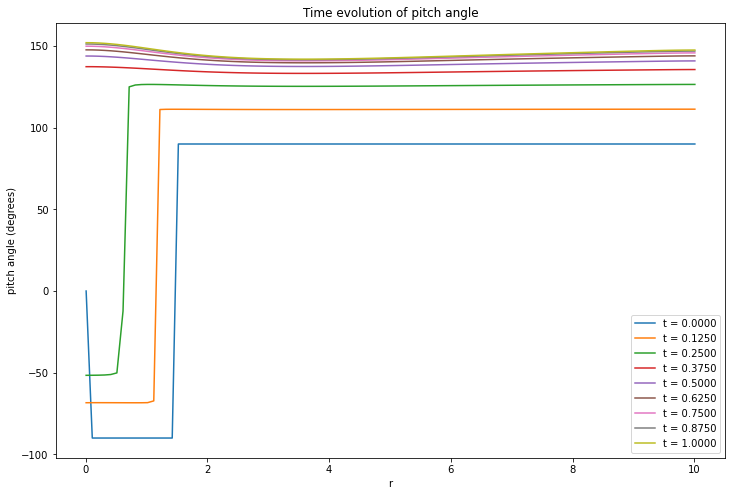

In [12]:
pitch_angle = np.degrees(np.arctan2(B_list[:, 1], B_list[:, 0]))

# plotting pitch angle time evolution

plt.figure(figsize=(12, 8))
for j in range(len(iterations_to_save_plot)):
    plt.plot(r, pitch_angle[iterations_to_save_plot[j]], label=f't = {iterations_to_save_plot[j] * T/Nt:.4f}')
plt.xlabel('r')
plt.ylabel('pitch angle (degrees)')
plt.title('Time evolution of pitch angle')
plt.legend()
if fig_save:
    plt.savefig(fig_path + 'pitch_angle_evolve_t.png')
plt.show()

### Exploring different seed field

In [13]:

# defining constants and parameters
eta = 1
r_i = 0.01  # start of spatial domain
r_f = 10.01 # end of spatial domain
T = 1.0  # Total simulation time
Nr = 100  # Number of spatial grid points
Nt = 5000  # Number of time steps
h = 1
order = 4 # order of the finite difference scheme
ghost_zone_type = 'symmetric' # type of the ghost zone
iterations_to_save = 'all' # which time steps to save
iterations_to_save_plot = [int(i * Nt/8) for i in range(8 + 1)] # which time steps to plot

r = np.linspace(r_i, r_f, Nr)
dr = (r_f - r_i) / (Nr - 1)

omega_0 = 50
r_omega = 4
h = 1
alpha = 0.5
alpha_cap = 1 #UPDATE

# defining the spatial dependent omega
omega = omega_0 / (np.sqrt(1 + (r / r_omega) ** 2))

# defining q
neg_q_omega = r * first_derivative_dYdx_FD(omega, dr, order = 4, ghost_zone_type='symmetric')

R_alpha = alpha * h / eta
R_omega = (neg_q_omega * (h ** 2)) / eta

D = R_alpha * R_omega

# defining initial conditions
def B_phi01(r, phi, z):
    return (4*np.sin(((r - r_i)/(r_f - r_i))*np.pi)) - (np.sin(((r - r_i)/(r_f - r_i))*5*np.pi)) - (np.sin(((r - r_i)/(r_f - r_i))*4*np.pi))

def B_r01(r, phi, z):
    return (4*np.sin(((r - r_i)/(r_f - r_i))*np.pi)) + (1.5*np.sin(((r - r_i)/(r_f - r_i))*6*np.pi)) + ( np.sin(((r - r_i)/(r_f - r_i))*1*np.pi))

def B_phi02(r, phi, z):
    return (4 * np.sin(((r - r_i)/(r_f - r_i))*3*np.pi)) + (1 * np.sin(((r - r_i)/(r_f - r_i))*6*np.pi)) + (2 * np.sin(((r - r_i)/(r_f - r_i))*5*np.pi))
 
def B_r02(r, phi, z):
    return (4 * np.sin(((r - r_i)/(r_f - r_i))*1*np.pi)) + (2 * np.sin(((r - r_i)/(r_f - r_i))*3*np.pi)) + (1.5 * np.sin(((r - r_i)/(r_f - r_i))*3*np.pi))

# definiing the time evolution of the magnetic field Br
def dBrdt(Br, Bphi, dBrdr, ddBrdr, t):
    return (- (2/(np.pi*h)) * R_alpha * alpha_cap* Bphi) + (eta * (ddBrdr + (dBrdr / r) - (Br/(r ** 2)) - (((np.pi ** 2) / (4 * (h**2))) * Br)))

# definiing the time evolution of the magnetic field Bphi
def dBphidt(Br, Bphi, dBphidr, ddBphidr, t):
    return (R_omega * Br) + (eta * (ddBphidr + (dBphidr / r) - (Bphi/(r ** 2)) - (((np.pi ** 2) / (4 * (h**2))) * Bphi)))

# running 2 simulations with different seed fields

B_list1 = sim_field(r_i, r_f, Nr, T, Nt, B_r01, B_phi01, dBrdt, dBphidt, order = order, ghost_zone_type = ghost_zone_type, iterations_to_save = iterations_to_save)
B_list2 = sim_field(r_i, r_f, Nr, T, Nt, B_r02, B_phi02, dBrdt, dBphidt, order = order, ghost_zone_type = ghost_zone_type, iterations_to_save = iterations_to_save)


100%|██████████| 5000/5000 [00:05<00:00, 861.85it/s]


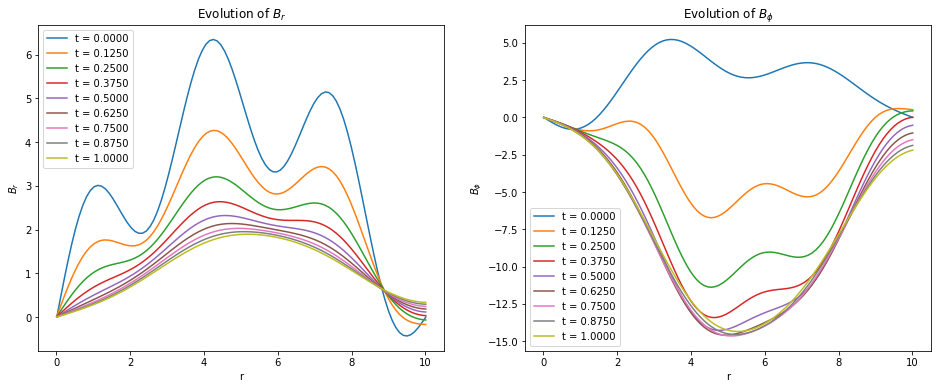

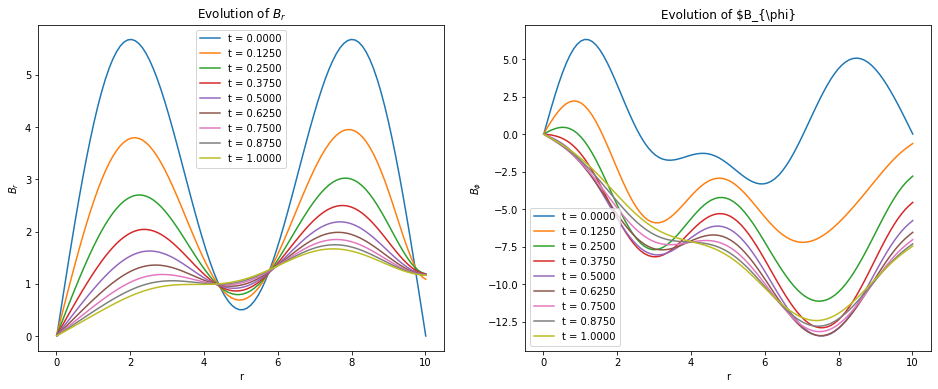

In [14]:

# plotting Br and Bphi time evolition in two plots side by side
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

axs[0].set_title('Evolution of $B_r$')
axs[1].set_title('Evolution of $B_{\phi}$')

axs[0].set_xlabel('r')
axs[1].set_xlabel('r')

axs[0].set_ylabel(r'$B_r$')
axs[1].set_ylabel(r'$B_{\phi}$')

for i, ax in enumerate(axs):
    for j in range(len(iterations_to_save_plot)):
        ax.plot(r, B_list1[iterations_to_save_plot[j], i], label=f't = {iterations_to_save_plot[j] * T/Nt:.4f}')
    ax.legend()

if fig_save:
    plt.savefig(fig_path + 'Br_Bphi_evolve_seed1.png')
plt.show()

# plotting Br and Bphi time evolition in two plots side by side in seed field 2
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

axs[0].set_title('Evolution of $B_r$')
axs[1].set_title('Evolution of $B_{\phi}')

axs[0].set_xlabel('r')
axs[1].set_xlabel('r')

axs[0].set_ylabel(r'$B_r$')
axs[1].set_ylabel(r'$B_{\phi}$')

for i, ax in enumerate(axs):
    for j in range(len(iterations_to_save_plot)):
        ax.plot(r, B_list2[iterations_to_save_plot[j], i], label=f't = {iterations_to_save_plot[j] * T/Nt:.4f}')
    ax.legend()

if fig_save:
    plt.savefig(fig_path + 'Br_Bphi_evolve_t_seed2.png')
plt.show()

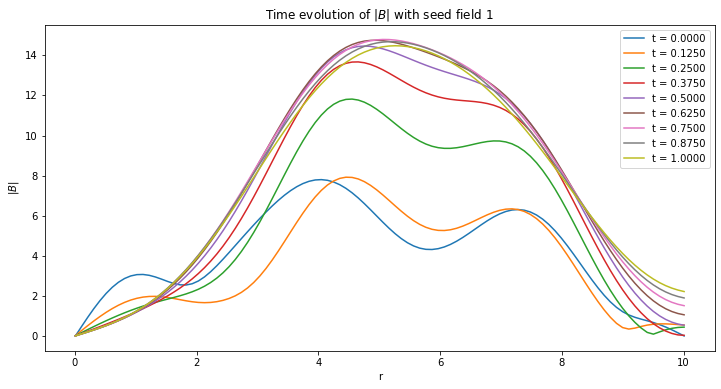

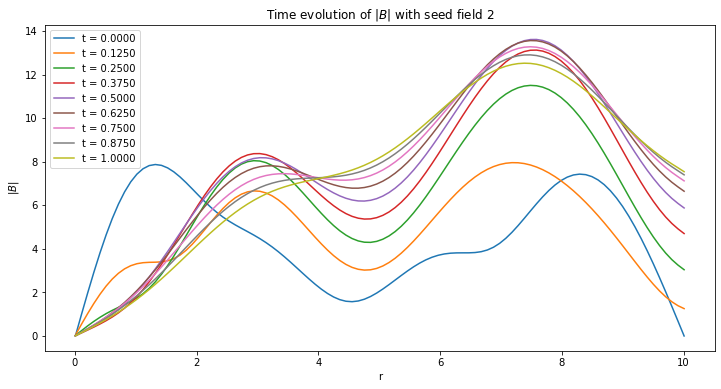

In [15]:
# evolution of their magnetic field strength
B_strength1 = np.sqrt(B_list1[:, 0] ** 2 + B_list1[:, 1] ** 2)
B_strength2 = np.sqrt(B_list2[:, 0] ** 2 + B_list2[:, 1] ** 2)

plt.figure(figsize=(12, 6))
for j in range(len(iterations_to_save_plot)):
    plt.plot(r, B_strength1[iterations_to_save_plot[j]], label=f't = {iterations_to_save_plot[j] * T/Nt:.4f}')
plt.xlabel('r')
plt.ylabel(r'$|B|$')
plt.title('Time evolution of $|B|$ with seed field 1')
plt.legend()
if fig_save:
    plt.savefig(fig_path + 'B_evolve_t_seed1.png')
plt.show()

plt.figure(figsize=(12, 6))
for j in range(len(iterations_to_save_plot)):
    plt.plot(r, B_strength2[iterations_to_save_plot[j]], label=f't = {iterations_to_save_plot[j] * T/Nt:.4f}')
plt.xlabel('r')
plt.ylabel(r'$|B|$')
plt.title('Time evolution of $|B|$ with seed field 2')
plt.legend()
if fig_save:
    plt.savefig(fig_path + 'B_evolve_t_seed2.png')
plt.show()

# Study of Magnetic field strength evolution close to critical Dynamo number

In [16]:
# defining constants and parameters
eta = 1
r_i = 0.01  # start of spatial domain
r_f = 10.01 # end of spatial domain
T = 10.0  # Total simulation time
Nr = 200  # Number of spatial grid points
Nt = int(T * 6000)  # Number of time steps
h = 1
order = 4 # order of the finite difference scheme
ghost_zone_type = 'symmetric' # type of the ghost zone
iterations_to_save = 'all' # which time steps to save
iterations_to_save_plot = [int(i * Nt/8) for i in range(8 + 1)] # which time steps to plot

r = np.linspace(r_i, r_f, Nr)
dr = (r_f - r_i) / (Nr - 1)

trial = 10




# defining initial conditions
def B_phi0(r, phi, z):
    return (4*np.sin(((r - r_i)/(r_f - r_i))*np.pi)) - (np.sin(((r - r_i)/(r_f - r_i))*5*np.pi)) - (np.sin(((r - r_i)/(r_f - r_i))*4*np.pi))

def B_r0(r, phi, z):
    return (4*np.sin(((r - r_i)/(r_f - r_i))*np.pi)) + (1.5*np.sin(((r - r_i)/(r_f - r_i))*6*np.pi)) + ( np.sin(((r - r_i)/(r_f - r_i))*1*np.pi))

# definiing the time evolution of the magnetic field Br
def dBrdt(Br, Bphi, dBrdr, ddBrdr, t):
    return (- (2/(np.pi*h)) * R_alpha * alpha_cap* Bphi) + (eta * (ddBrdr + (dBrdr / r) - (Br/(r ** 2)) - (((np.pi ** 2) / (4 * (h**2))) * Br)))

# definiing the time evolution of the magnetic field Bphi
def dBphidt(Br, Bphi, dBphidr, ddBphidr, t):
    return (R_omega * Br) + (eta * (ddBphidr + (dBphidr / r) - (Bphi/(r ** 2)) - (((np.pi ** 2) / (4 * (h**2))) * Bphi)))


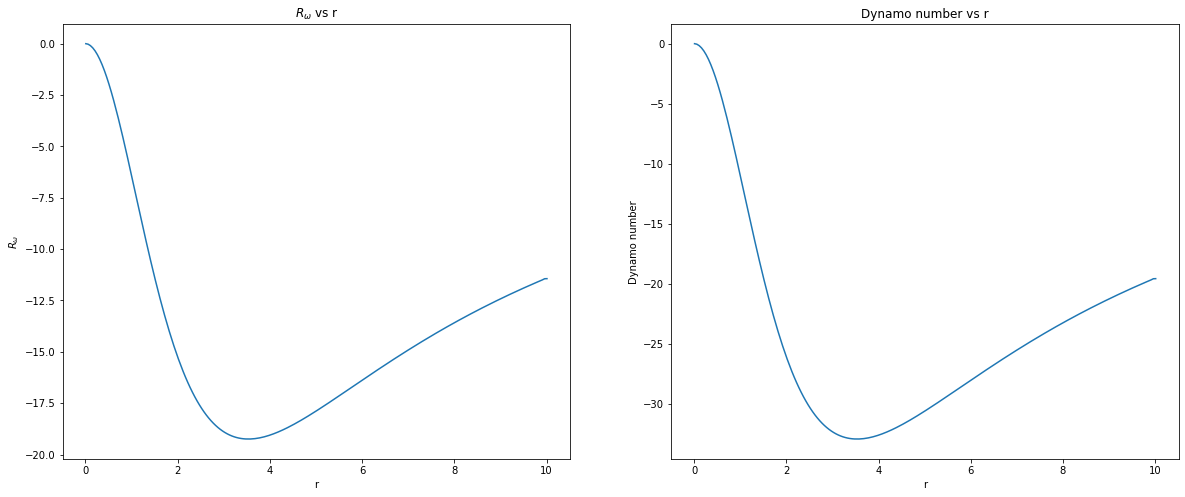

In [17]:
omega_0 = 50
r_omega = 2.5
h = 1
alpha_cap = 1 
# defining the spatial dependent omega
omega = omega_0 / (np.sqrt(1 + (r / r_omega) ** 2))

# defining q
neg_q_omega = r * first_derivative_dYdx_FD(omega, dr, order = 4, ghost_zone_type='smooth')

R_alpha = 1.71
R_omega = (neg_q_omega * (h ** 2)) / eta

D = R_alpha * R_omega

# plotting the omega values and dynamo number values across the spatial domain side by side

fig, axs = plt.subplots(1, 2, figsize=(20, 8))

axs[0].plot(r, R_omega)
axs[0].set_xlabel('r')
axs[0].set_ylabel(r'$R_{\omega}$')
axs[0].set_title(r'$R_{\omega}$ vs r')

axs[1].plot(r, D)
axs[1].set_xlabel('r')
axs[1].set_ylabel('Dynamo number')
axs[1].set_title('Dynamo number vs r')

if fig_save:
    plt.savefig(fig_path + f'omega_D_vs_r_trial{trial}.png')
plt.show()

In [18]:
# running the simulations

B_list = sim_field(r_i, r_f, Nr, T, Nt, B_r0, B_phi0, dBrdt, dBphidt, order = order, ghost_zone_type = ghost_zone_type, iterations_to_save = iterations_to_save)


100%|██████████| 60000/60000 [02:20<00:00, 426.47it/s]


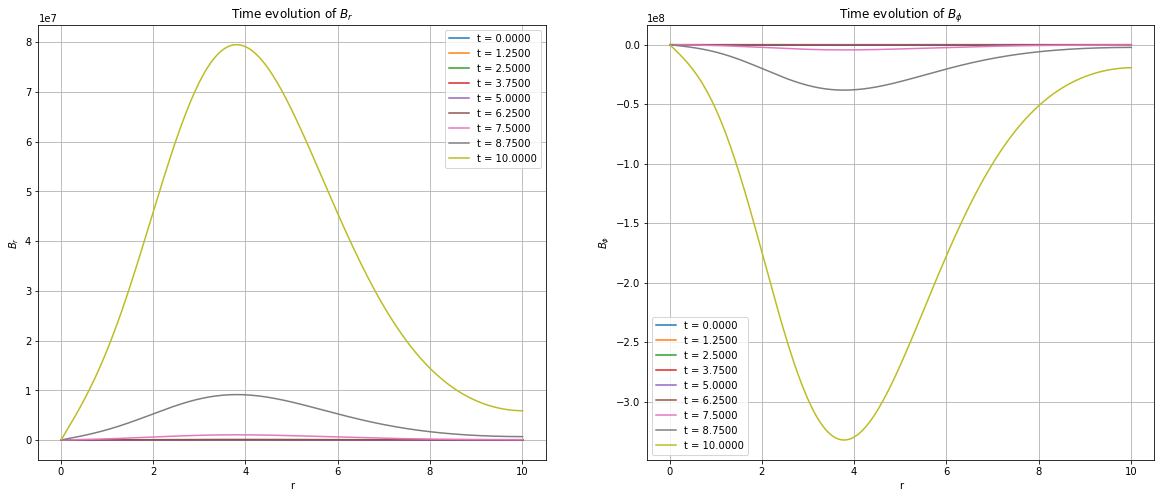

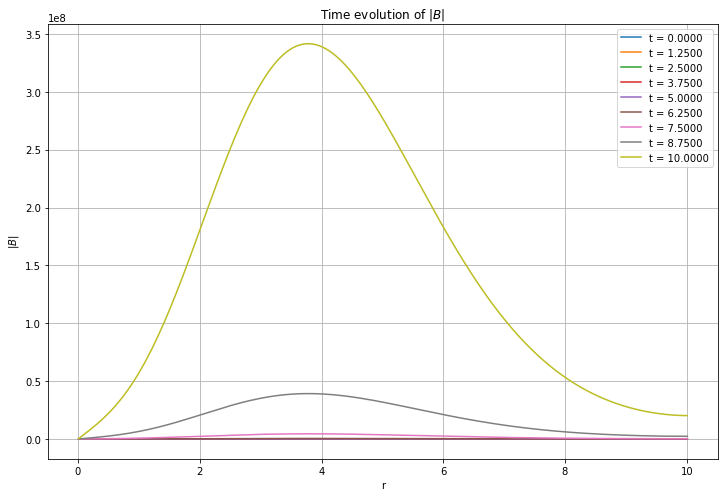

In [26]:
# plotting Br and Bphi time evolution in two plots side by side

fig, axs = plt.subplots(1, 2, figsize=(20, 8))

for i, ax in enumerate(axs):
    for j in range(len(iterations_to_save_plot)):
        ax.plot(r, B_list[iterations_to_save_plot[j], i], label=f't = {iterations_to_save_plot[j] * T/Nt:.4f}')
    ax.set_xlabel('r')
    if i == 0:
        name = r'$B_r$'
    else:
        name = r'$B_{\phi}$'
    ax.set_ylabel(name)
    ax.set_title(f'Time evolution of {name}')
    ax.grid()
    ax.legend()

if fig_save:
    plt.savefig(fig_path + f'Br_Bphi_evolution_t_trial{trial}.png')
plt.show()
#print(f"saved figure at {fig_path + f'Br_Bphi_evolution_t_trial{trial}.png'}")


# plotting magnetic field strength time evolution

B_strength = np.sqrt(B_list[:, 0] ** 2 + B_list[:, 1] ** 2)

plt.figure(figsize=(12, 8))
for j in range(len(iterations_to_save_plot)):
    plt.plot(r, B_strength[iterations_to_save_plot[j]], label=f't = {iterations_to_save_plot[j] * T/Nt:.4f}')
plt.xlabel('r')
plt.ylabel(r'$|B|$')
plt.title('Time evolution of $|B|$')
plt.legend()
plt.grid()
if fig_save:
    plt.savefig(fig_path + f'B_evolution_t_trial{trial}.png')
plt.show()

Points where gamma crosses 0: [9.35673367]
Dynamo numbers: [-10.29985394]


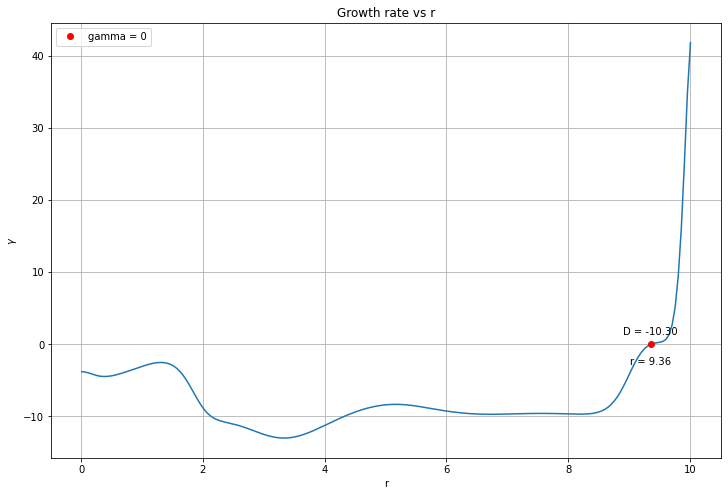

In [34]:
B_strength = B_strength.T

cutoff_index1 = int(Nt * 0.001)
cutoff_index2 = int(1 * Nt // 500)
slopes = []
for i in range(Nr):
    slope, intercept = np.polyfit(np.linspace(0,T,Nt+1)[cutoff_index1:cutoff_index2], np.log(B_strength[i][cutoff_index1:cutoff_index2]), 1)
    slopes.append(slope)
    
slopes = np.array(slopes)
growth_rates = 10**(slopes) - 1
decay_rates = 1 - 10**(slopes)
gamma = slopes

# points where gamma crosses 0
r_zeros = r[np.where(np.diff(np.sign(gamma)))[0]]
print(f'Points where gamma crosses 0: {r_zeros}')
print(f'Dynamo numbers: {D[np.where(np.diff(np.sign(gamma)))[0]]/2}')
    
# plotting gamma vs r
plt.figure(figsize=(12, 8))
plt.plot(r, gamma)
plt.xlabel('r')
plt.ylabel(r'$\gamma$')
plt.title('Growth rate vs r')
plt.grid()
plt.plot(r_zeros, np.zeros(len(r_zeros)), 'ro', label = 'gamma = 0')
for i in range(len(r_zeros)):
    plt.annotate(f'D = {D[np.where(np.diff(np.sign(gamma)))[0][i]]/2:.2f}', (r_zeros[i], 0), textcoords="offset points", xytext=(0,10), ha='center')
    plt.annotate(f'r = {r_zeros[i]:.2f}', (r_zeros[i], 0), textcoords="offset points", xytext=(0,-20), ha='center')
plt.legend()
if fig_save:
    plt.savefig(fig_path + f'gamma_vs_r_trial{trial}_withDc.png')
plt.show()

-9.563115149540044


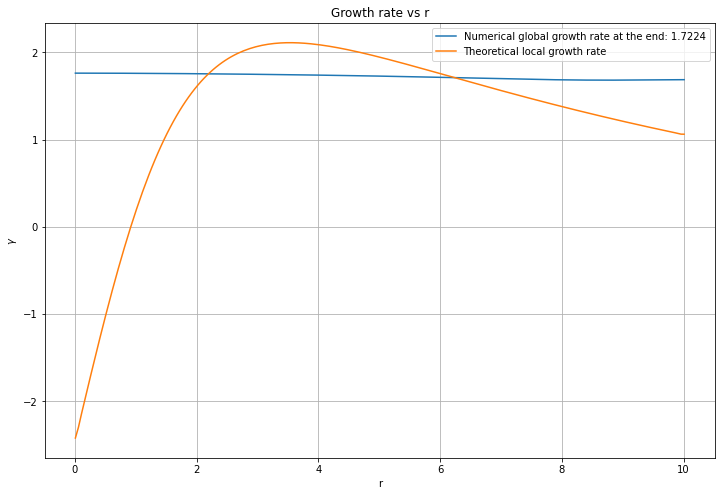

In [35]:
cutoff_index1 = int(Nt * 0.1)
cutoff_index2 = int(Nt)

slopes = []
for i in range(Nr):
    slope, intercept = np.polyfit(np.linspace(0,T,Nt+1)[cutoff_index1:cutoff_index2], np.log(B_strength[i][cutoff_index1:cutoff_index2]), 1)
    slopes.append(slope)
    
slopes = np.array(slopes)
growth_rates = 10**(slopes) - 1
decay_rates = 1 - 10**(slopes)
gamma = slopes

### Theoretical values
t_d = 1
Dc = - (np.pi ** 5) / 32
local_gamma_theoretical = (np.sqrt(2 / np.pi) / t_d) * (np.sqrt(-D) - np.sqrt(-Dc))
print(Dc)
# plotting gamma vs r
plt.figure(figsize=(12, 8))
plt.plot(r, gamma, label = f'Numerical global growth rate at the end: {np.mean(gamma):.4f}')
plt.plot(r, local_gamma_theoretical, label = f'Theoretical local growth rate')
plt.xlabel('r')
plt.ylabel(r'$\gamma$')
plt.title('Growth rate vs r')
plt.grid()
plt.legend()
if fig_save:
    plt.savefig(fig_path + f'gamma_vs_r_trial{trial}_global.png')
plt.show()